In [1]:
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.io import savemat
import math

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import time

In [3]:
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

# 0. Define the Grid

In [4]:
delta = 0.05
x_domain = np.arange(0, 5, delta)
y_domain = np.arange(0, 3, delta)
x_mesh,y_mesh = np.meshgrid(x_domain, y_domain)

# 1. Define Physical Info.

    suppose: 
    x = X[0];
    y = X[1];
    uxy = X[2]; 
    dudx = X[3];
    dudy = X[4];
    du2dx2 = X[5];
    du2dy2 = X[6];
    du2dxdy = X[7];
    laplace = X[8]

In [5]:
governing_equation_components = []
governing_equation_components.append(Lambda(lambda x: tf.sin(x[2]**2)))
governing_equation_components.append(Lambda(lambda x: x[8]))
governing_equation_components.append(Lambda(lambda x: tf.sin(tf.sin(x[0]**2+x[1]**2)**2) + 4*tf.cos(x[0]**2+x[1]**2) - 4*(x[0]**2+x[1]**2)*tf.sin(x[0]**2+x[1]**2)))

In [6]:
estimate_equation_form = False
equation_component_combination = [1.0,1.0,-1.0]

# 2. Define the Observations

    suppose: 
    x = X[0];
    y = X[1];
    uxy = X[2]; 
    dudx = X[3];
    dudy = X[4];
    du2dx2 = X[5];
    du2dy2 = X[6];
    du2dxdy = X[7];
    laplace = X[8]

In [7]:
observation_components = []
observation_components.append(Lambda(lambda x: x[2]))
observation_components.append(Lambda(lambda x: x[3]))
observation_components.append(Lambda(lambda x: x[4]))

    format: [x,y,combination,value]

In [8]:
observation_data = []
# bottom
for x in x_domain:
    y = y_domain[0]
    comb = [1,0,0]
    v = np.sin(x**2+y**2)
    observation_data.append([x,y,comb,v])
# left
for y in y_domain:
    x = x_domain[0]
    comb = [0,-1,0]
    v = -2*x*np.cos(x**2+y**2)
    observation_data.append([x,y,comb,v])
# up
for x in x_domain:
    y = y_domain[-1]
    comb = [1,0,0]
    v = np.sin(x**2+y**2)
    observation_data.append([x,y,comb,v])   
# right
for y in y_domain:
    x = x_domain[-1]
    comb = [1,0,0]
    v = np.sin(x**2+y**2)
    observation_data.append([x,y,comb,v])
# additional
#for y in y_domain:
#    x = x_domain[len(x_domain)//2]
#    comb = [1,0,0]
#    v = np.sin(x**2+y**2)
#    observation_data.append([x,y,comb,v])   

# 3. Define PICN

In [9]:
def gradient_x_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[[-1.0/delta]], [[1.0/delta]]]], dtype=dtype)

In [10]:
def gradient_x2_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[[1.0/delta**2]], [[-2.0/delta**2]], [[1.0/delta**2]]]], dtype=dtype)

In [11]:
def gradient_y_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[[-1.0/delta]]], [[[1.0/delta]]]], dtype=dtype)

In [12]:
def gradient_y2_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[[1.0/delta**2]]], [[[-2.0/delta**2]]], [[[1.0/delta**2]]]], dtype=dtype)

In [13]:
def gradient_xy_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[[1.0/delta**2]], [[-1.0/delta**2]]], [[[-1.0/delta**2]], [[1.0/delta**2]]]], dtype=dtype)

In [14]:
def laplace_kernal_init(shape, dtype=tf.float32):
    return tf.constant([[[[0]], [[1.0/delta**2]], [[0]]], [[[1.0/delta**2]], [[-4.0/delta**2]], [[1.0/delta**2]]], [[[0]], [[1.0/delta**2]], [[0]]]], dtype=dtype)

In [15]:
inputs = [keras.layers.Input(shape=(1,1,1)),
          keras.layers.Input(shape=(len(y_domain),len(x_domain),1)),
          keras.layers.Input(shape=(len(y_domain),len(x_domain),1)),
          keras.layers.Input(shape=(len(observation_data),len(observation_components)*4))]

hidden_field = keras.layers.Conv2DTranspose(filters=1, 
                                            kernel_size=[len(y_domain)+4,len(x_domain)+4], 
                                            activation='linear')(inputs[0])
coordinates_x = inputs[1]
coordinates_y = inputs[2]
field = keras.layers.Conv2D(filters=1, 
                            kernel_size=3, 
                            padding='valid', 
                            activation=Lambda(lambda x: x+tf.tanh(x)))(hidden_field)
gradient_x_field = keras.layers.Conv2D(filters=1, 
                                     kernel_size=[1,2], 
                                     padding='valid',
                                     use_bias=False,
                                     trainable=False,
                                     kernel_initializer=gradient_x_kernal_init)(field)
gradient_x2_field = keras.layers.Conv2D(filters=1, 
                                       kernel_size=[1,3], 
                                       padding='valid',
                                       use_bias=False,
                                       trainable=False,
                                       kernel_initializer=gradient_x2_kernal_init)(field)
gradient_y_field = keras.layers.Conv2D(filters=1, 
                                     kernel_size=[2,1], 
                                     padding='valid',
                                     use_bias=False,
                                     trainable=False,
                                     kernel_initializer=gradient_y_kernal_init)(field)
gradient_y2_field = keras.layers.Conv2D(filters=1, 
                                       kernel_size=[3,1], 
                                       padding='valid',
                                       use_bias=False,
                                       trainable=False,
                                       kernel_initializer=gradient_y2_kernal_init)(field)
gradient_xy_field = keras.layers.Conv2D(filters=1, 
                                       kernel_size=[2,2], 
                                       padding='valid',
                                       use_bias=False,
                                       trainable=False,
                                       kernel_initializer=gradient_xy_kernal_init)(field)
laplace_field = keras.layers.Conv2D(filters=1, 
                                       kernel_size=[3,3], 
                                       padding='valid',
                                       use_bias=False,
                                       trainable=False,
                                       kernel_initializer=laplace_kernal_init)(field)
phycial_fields = [coordinates_x,
                  coordinates_y,
                  field[:,1:-1,1:-1,:],
                  gradient_x_field[:,1:-1,1:,:],
                  gradient_y_field[:,1:,1:-1,:],
                  gradient_x2_field[:,1:-1,:,:],
                  gradient_y2_field[:,:,1:-1,:],
                  gradient_xy_field[:,1:,1:,:],
                  laplace_field]

In [16]:
if estimate_equation_form==True:
    tf_governing_equation_components = [component(phycial_fields) for component in governing_equation_components]
    concat_equation_components = Lambda(lambda x: tf.concat(x,axis=-1))(tf_governing_equation_components)
    governing_equation = keras.layers.Conv2D(filters=1, 
                                             kernel_size=[1,1], 
                                             padding='valid',
                                             use_bias=False)(concat_equation_components)
else:
    tf_weighted_governing_equation_components = [weight*component(phycial_fields) for [weight,component] in zip(equation_component_combination,governing_equation_components)]
    concat_weighted_equation_components = Lambda(lambda x: tf.concat(x,axis=-1))(tf_weighted_governing_equation_components)
    governing_equation = Lambda(lambda x: tf.reduce_sum(x,axis=-1,keepdims=True))(concat_weighted_equation_components)

In [17]:
tf_observation_components = [component(phycial_fields) for component in observation_components]
concat_observation_components = Lambda(lambda x: tf.concat(x,axis=-1))(tf_observation_components)

In [18]:
left_x_position_index_list = []
right_x_position_index_list = []
left_x_position_weight_list = []
right_x_position_weight_list = []

bottom_y_position_index_list = []
top_y_position_index_list = []
bottom_y_position_weight_list = []
top_y_position_weight_list = []


for data in observation_data:
    
    left_x_position_index = int(np.floor((data[0] - x_domain[0])/delta))
    right_x_position_index = left_x_position_index + 1
    left_x_position_weight = 1-(data[0] - (x_domain[0]+delta*left_x_position_index))/delta
    right_x_position_weight = 1-left_x_position_weight
    
    bottom_y_position_index = int(np.floor((data[1] - y_domain[0])/delta))
    top_y_position_index = bottom_y_position_index + 1
    bottom_y_position_weight = 1-(data[1] - (y_domain[0]+delta*bottom_y_position_index))/delta
    top_y_position_weight = 1-bottom_y_position_weight
    
    if data[0] <= x_domain[0] + 1e-8:
        left_x_position_index = 0
        right_x_position_index = 1
        left_x_position_weight = 1
        right_x_position_weight = 0
    if data[0] >= x_domain[-1] - 1e-8:
        left_x_position_index = len(x_domain)-2
        right_x_position_index = len(x_domain)-1
        left_x_position_weight = 0
        right_x_position_weight = 1
    if data[1] <= y_domain[0] + 1e-8:
        bottom_y_position_index = 0
        top_y_position_index = 1
        bottom_y_position_weight = 1
        top_y_position_weight = 0
    if data[1] >= y_domain[-1] - 1e-8:
        bottom_y_position_index = len(y_domain)-2
        top_y_position_index = len(y_domain)-1
        bottom_y_position_weight = 0
        top_y_position_weight = 1
    
    left_x_position_index_list.append(left_x_position_index)
    right_x_position_index_list.append(right_x_position_index)
    left_x_position_weight_list.append(left_x_position_weight)
    right_x_position_weight_list.append(right_x_position_weight)

    bottom_y_position_index_list.append(bottom_y_position_index)
    top_y_position_index_list.append(top_y_position_index)
    bottom_y_position_weight_list.append(bottom_y_position_weight)
    top_y_position_weight_list.append(top_y_position_weight)

In [19]:
left_bottom_indices = tf.constant([[0,y,x] for x,y in zip(left_x_position_index_list,bottom_y_position_index_list)])
left_top_indices = tf.constant([[0,y,x] for x,y in zip(left_x_position_index_list,top_y_position_index_list)])
right_bottom_indices = tf.constant([[0,y,x] for x,y in zip(right_x_position_index_list,bottom_y_position_index_list)])
right_top_indices = tf.constant([[0,y,x] for x,y in zip(right_x_position_index_list,top_y_position_index_list)])

In [20]:
observation_data_left_bottom_part = Lambda(lambda x: tf.gather_nd(x,left_bottom_indices))(concat_observation_components)
observation_data_left_top_part = Lambda(lambda x: tf.gather_nd(x,left_top_indices))(concat_observation_components)
observation_data_right_bottom_part = Lambda(lambda x: tf.gather_nd(x,right_bottom_indices))(concat_observation_components)
observation_data_right_top_part = Lambda(lambda x: tf.gather_nd(x,right_top_indices))(concat_observation_components)

In [21]:
observation_data_four_part = Lambda(lambda x: tf.expand_dims(tf.concat(x,axis=-1),axis=0))([observation_data_left_bottom_part,observation_data_left_top_part,observation_data_right_bottom_part,observation_data_right_top_part])

In [22]:
observation_data_interpolation_weights = np.expand_dims(
np.asarray([np.concatenate([(np.asarray([observation_data[i][2][j] for j in range(len(observation_components))]))*left_x_position_weight_list[i]*bottom_y_position_weight_list[i],
 (np.asarray([observation_data[i][2][j] for j in range(len(observation_components))]))*left_x_position_weight_list[i]*top_y_position_weight_list[i],
 (np.asarray([observation_data[i][2][j] for j in range(len(observation_components))]))*right_x_position_weight_list[i]*bottom_y_position_weight_list[i],
 (np.asarray([observation_data[i][2][j] for j in range(len(observation_components))]))*right_x_position_weight_list[i]*top_y_position_weight_list[i]],axis=-1) for i in range(len(observation_data))]),
    axis=0)

In [23]:
observations = Lambda(lambda x: tf.reduce_sum(x[0]*x[1],axis=-1))([inputs[3][0,:,:],observation_data_four_part])

In [24]:
pde_model = keras.Model(inputs=inputs[:3], outputs=phycial_fields)
pde_model_train = keras.Model(inputs=inputs, outputs=[governing_equation,observations])

In [25]:
def model_print_functoin(s):
    with open('model_summary.txt','a') as f:
        print(s, file=f)

pde_model.summary(print_fn=model_print_functoin)
pde_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 1, 1)]            0         []                            
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 64, 104, 1)           6657      ['input_1[0][0]']             
 anspose)                                                                                         
                                                                                                  
 conv2d (Conv2D)             (None, 62, 102, 1)           10        ['conv2d_transpose[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)           (None, 62, 101, 1)           2         ['conv2d[0][0]']          

# 4. Prepare the Training Data

In [26]:
unit_constant = np.asarray([[[[1.0]]]],dtype=np.float32)
training_input_data_0 = unit_constant
print(training_input_data_0.shape)

(1, 1, 1, 1)


In [27]:
training_input_data_1 = np.expand_dims(x_mesh.astype(np.float32),axis=[0,-1])
print(training_input_data_1.shape)

(1, 60, 100, 1)


In [28]:
training_input_data_2 = np.expand_dims(y_mesh.astype(np.float32),axis=[0,-1])
print(training_input_data_2.shape)

(1, 60, 100, 1)


In [29]:
training_input_data_3 = observation_data_interpolation_weights.astype(np.float32)
print(training_input_data_3.shape)

(1, 320, 12)


In [30]:
training_label_data_0 = np.zeros([1,pde_model_train.output[0].shape[1],pde_model_train.output[0].shape[2],1])
print(training_label_data_0.shape)

(1, 60, 100, 1)


In [31]:
training_label_data_1 = np.expand_dims(np.asarray([data[3] for data in observation_data]),axis=[0])
print(training_label_data_1.shape)

(1, 320)


In [32]:
training_input_data = [training_input_data_0,training_input_data_1,training_input_data_2,training_input_data_3]
training_label_data = [training_label_data_0,training_label_data_1]

# 6. Train the Model

In [33]:
pde_model_train.compile(optimizer=keras.optimizers.Adam(), loss="mse")
pde_model_train.save_weights('picn_initial_weights.h5')
temp_history = pde_model_train.fit(x=training_input_data, y=training_label_data, epochs=1, verbose=0)
history_keys = []
for key in temp_history.history.keys():
    history_keys.append(key)
print(history_keys)

['loss', 'lambda_8_loss', 'lambda_15_loss']


In [34]:
def record_predictions():
    [_, _, uxy, dudx, dudy, d2udx2, d2udy2, d2udxdy, laplace] = pde_model.predict(training_input_data[:3])
    uxy_list.append(uxy[:,:,:,0])
    dudx_list.append(dudx[:,:,:,0])
    dudy_list.append(dudy[:,:,:,0])
    d2udx2_list.append(d2udx2[:,:,:,0])
    d2udy2_list.append(d2udy2[:,:,:,0])
    d2udxdy_list.append(d2udxdy[:,:,:,0])
    laplace_list.append(laplace[:,:,:,0])

class Per_X_Epoch_Record(tf.keras.callbacks.Callback):
    def __init__(self, record_interval, verbose=1):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.total_loss = history_keys[0]
        self.domain_loss = history_keys[1]
        self.bdc_loss = history_keys[2]
        self.previous_total_loss = 9999999
        self.record_interval = record_interval;
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        
        if epoch%self.record_interval == 0:
            
            current_total_loss = logs.get(self.total_loss)
            current_domain_loss = logs.get(self.domain_loss)
            current_bdc_loss = logs.get(self.bdc_loss)
            
            epoch_number_list.append(epoch)
            total_loss_list.append(current_total_loss)
            domain_loss_list.append(current_domain_loss)
            boundary_loss_list.append(current_bdc_loss)
        
            if current_total_loss < self.previous_total_loss:
                self.previous_total_loss = current_total_loss
                pde_model_train.save_weights('picn_best_weights.h5')
            
            if self.verbose > 0:
                print("epoch: {:10.5f} | total_loss: {:10.5f} | domain_loss: {:10.5f} | bdc_loss: {:10.5f}".format(epoch,current_total_loss,current_domain_loss,current_bdc_loss))
        
            # evaluate the errors in f-domain
            record_predictions()

In [35]:
callbacks = [
    Per_X_Epoch_Record(record_interval=100,verbose=1),
]

In [36]:
epoch_number_list = []
total_loss_list = []
domain_loss_list = []
boundary_loss_list = []
uxy_list = []
dudx_list = []
dudy_list = []
d2udx2_list = []
d2udy2_list = []
d2udxdy_list = []
laplace_list = []
pde_model_train.load_weights('picn_initial_weights.h5')
pde_model_train.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", loss_weights = [0.01, 0.99])

# Record the training time cost
start = time.time()

# Training
pde_model_train.fit(x=training_input_data, 
                    y=training_label_data, 
                    epochs=20000, verbose=0,
                    callbacks=callbacks)

# Record the training time cost
end = time.time()
print("Training time cost: {:10.5f} seconds".format(end - start))
time_costs_text_file = open("time_costs.txt", "w")
time_costs_text_file.write("Training time cost: {:10.5f} seconds".format(end - start))
time_costs_text_file.close()

# Load the best weights
pde_model_train.load_weights('picn_best_weights.h5')

epoch:    0.00000 | total_loss:   31.22898 | domain_loss: 3077.76538 | bdc_loss:    0.45589
1/1 [==============================] - 0s 65ms/step
epoch:  100.00000 | total_loss:   11.15823 | domain_loss: 1083.39514 | bdc_loss:    0.32755
1/1 [==============================] - 0s 11ms/step
epoch:  200.00000 | total_loss:    4.61772 | domain_loss:  431.26620 | bdc_loss:    0.30814
1/1 [==============================] - 0s 11ms/step
epoch:  300.00000 | total_loss:    1.44564 | domain_loss:  118.42062 | bdc_loss:    0.26407
1/1 [==============================] - 0s 11ms/step
epoch:  400.00000 | total_loss:    0.66258 | domain_loss:   46.25644 | bdc_loss:    0.20204
1/1 [==============================] - 0s 10ms/step
epoch:  500.00000 | total_loss:    0.38163 | domain_loss:   23.85177 | bdc_loss:    0.14456
1/1 [==============================] - 0s 15ms/step
epoch:  600.00000 | total_loss:    0.24128 | domain_loss:   14.32359 | bdc_loss:    0.09903
1/1 [==============================] - 0s 11

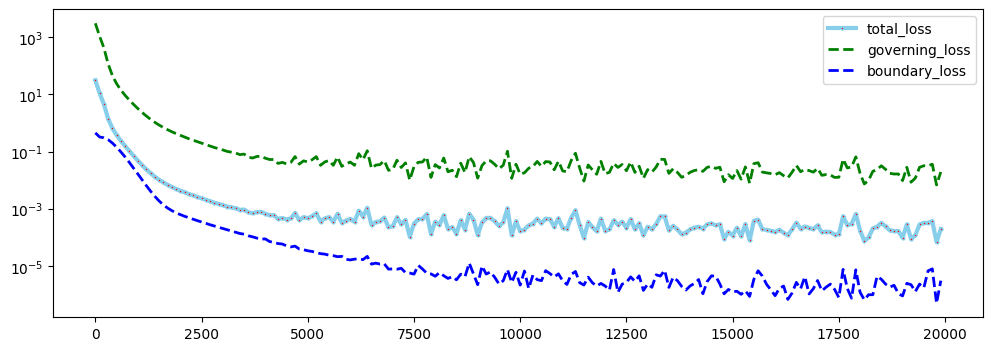

In [37]:
df=pd.DataFrame({'epoch': epoch_number_list, 
                 'total_loss': total_loss_list, 
                 'governing_loss': domain_loss_list, 
                 'boundary_loss': boundary_loss_list})

plt.figure(figsize=(12, 4))
plt.plot( 'epoch', 'total_loss', data=df, marker='o', markerfacecolor='red', markersize=2, color='skyblue', linewidth=3)
plt.plot( 'epoch', 'governing_loss', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
plt.plot( 'epoch', 'boundary_loss', data=df, marker='', color='blue', linewidth=2, linestyle='dashed')
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [38]:
[x_m, y_m, uxy, dudx, dudy, d2udx2, d2udy2, d2udxdy, laplace] = pde_model.predict(training_input_data[:3])

1/1 [==============================] - 0s 11ms/step


In [39]:
def U(x,y):
    return np.sin(x**2+y**2)

def dUdx(x,y):
    return 2*x*np.cos(x**2+y**2)

def dUdy(x,y):
    return 2*y*np.cos(x**2+y**2)

def d2Udx2(x,y):
    return 2*np.cos(x**2+y**2)-4*x**2*np.sin(x**2+y**2)

def d2Udy2(x,y):
    return 2*np.cos(x**2+y**2)-4*y**2*np.sin(x**2+y**2)

Text(0, 0.5, 'y')

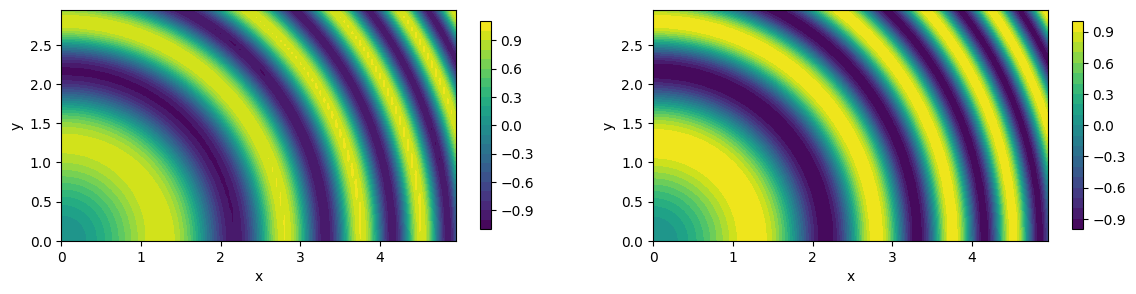

In [40]:
fig, axs = plt.subplots(1,2,constrained_layout=False, figsize=(14, 3))
#
ax = axs.ravel()[0]
cs = ax.contourf(x_domain, y_domain, uxy[0,:,:,0],20)
fig.colorbar(cs, ax=ax, shrink=0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')
#
ax = axs.ravel()[1]
cs = ax.contourf(x_domain, y_domain, U(x_mesh,y_mesh),20)
fig.colorbar(cs, ax=ax, shrink=0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

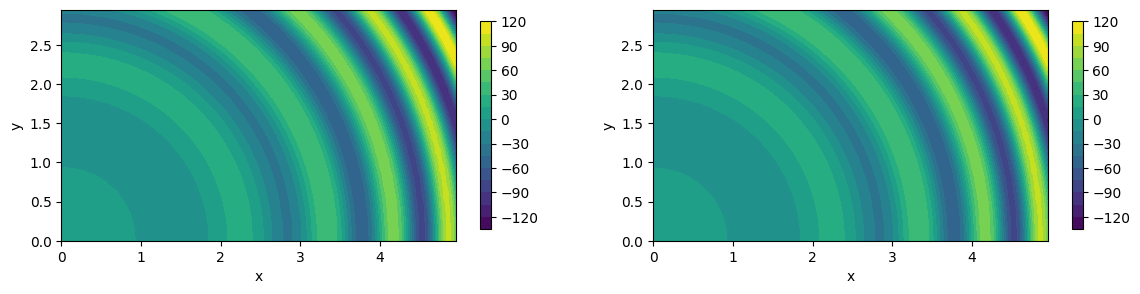

In [41]:
fig, axs = plt.subplots(1,2,constrained_layout=False, figsize=(14, 3))
#
ax = axs.ravel()[0]
cs = ax.contourf(x_domain, y_domain, laplace[0,:,:,0],20)
fig.colorbar(cs, ax=ax, shrink=0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')
#
ax = axs.ravel()[1]
cs = ax.contourf(x_domain, y_domain, d2Udx2(x_mesh,y_mesh)+d2Udy2(x_mesh,y_mesh),20)
fig.colorbar(cs, ax=ax, shrink=0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

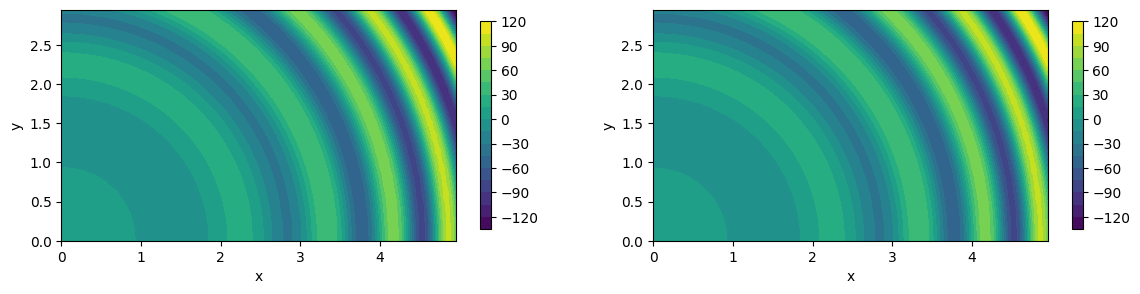

In [42]:
fig, axs = plt.subplots(1,2,constrained_layout=False, figsize=(14, 3))
#
ax = axs.ravel()[0]
cs = ax.contourf(x_domain, y_domain, (d2udx2+d2udy2)[0,:,:,0],20)
fig.colorbar(cs, ax=ax, shrink=0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')
#
ax = axs.ravel()[1]
cs = ax.contourf(x_domain, y_domain, d2Udx2(x_mesh,y_mesh)+d2Udy2(x_mesh,y_mesh),20)
fig.colorbar(cs, ax=ax, shrink=0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')

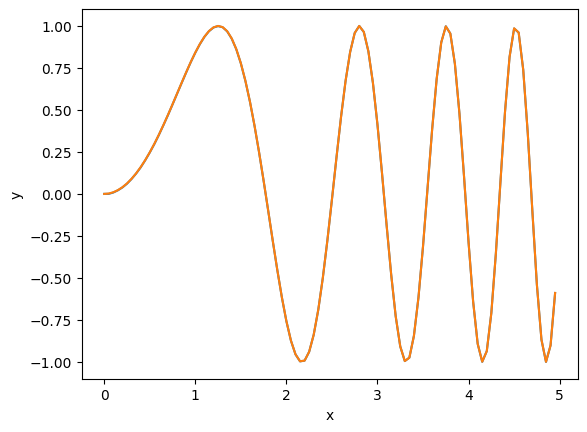

In [43]:
plt.plot(x_domain, uxy[0,0,:,0])
plt.plot(x_domain, (U(x_mesh,y_mesh))[0,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

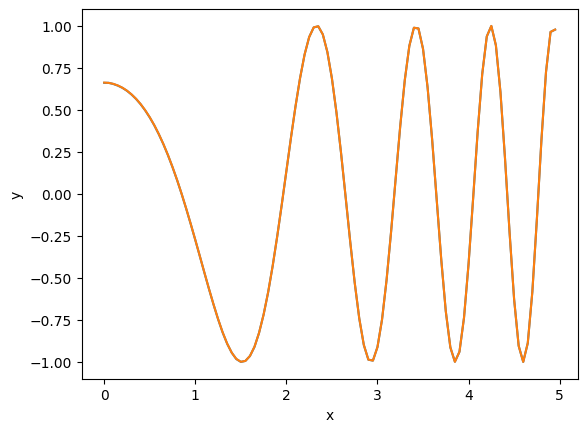

In [44]:
plt.plot(x_domain, uxy[0,-1,:,0])
plt.plot(x_domain, (U(x_mesh,y_mesh))[-1,:])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 7. Save the Process Data

In [45]:
picn_process_data = {'x_domain':x_domain,
                     'y_domain':y_domain,
                     'epoch_number_list':np.asarray(epoch_number_list),
                     'total_loss_list':np.asarray(total_loss_list),
                     'domain_loss_list':np.asarray(domain_loss_list),
                     'boundary_loss_list':np.asarray(boundary_loss_list),
                     'uxy_list':np.concatenate(uxy_list,axis=0),
                     'dudx_list':np.concatenate(dudx_list,axis=0),
                     'dudy_list':np.concatenate(dudy_list,axis=0),
                     'd2udx2_list':np.concatenate(d2udx2_list,axis=0),
                     'd2udy2_list':np.concatenate(d2udy2_list,axis=0),
                     'd2udxdy_list':np.concatenate(d2udxdy_list,axis=0),
                     'laplace_list':np.concatenate(laplace_list,axis=0)}
savemat('picn_process_data.mat', picn_process_data)